In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 125
import seaborn as sns
from Bio import SeqIO, Seq
import scipy.stats as st
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
import glob, os, yaml, subprocess, itertools, sparse

who_variants_combined = pd.read_csv("who_confidence_2021.csv")
drug_gene_mapping = pd.read_csv("../data/drug_gene_mapping.csv")
samples_summary = pd.read_csv("../data/samples_summary.csv")
snp_scheme = pd.read_csv("../data/coll2014_SNP_scheme.tsv", sep="\t")
snp_scheme["#lineage"] = snp_scheme["#lineage"].str.replace("lineage", "")
snp_scheme.rename(columns={"#lineage": "Lineage"}, inplace=True)

import warnings
warnings.filterwarnings(action='ignore')
from stats_utils import *

# CHANGE ANALYSIS DIR BEFORE RUNNING THE NOTEBOOK!
analysis_dir = '/n/data1/hms/dbmi/farhat/Sanjana/who-mutation-catalogue'

In [15]:
drugs_lst = os.listdir(analysis_dir)

drug_abbr_dict = {"Delamanid": "DLM",
                  "Bedaquiline": "BDQ",
                  "Clofazimine": "CFZ",
                  "Ethionamide": "ETH",
                  "Linezolid": "LZD",
                  "Moxifloxacin": "MXF",
                  "Capreomycin": "CAP",
                  "Amikacin": "AMI",
                  "Pretomanid": "PTM",
                  "Pyrazinamide": "PZA",
                  "Kanamycin": "KAN",
                  "Levofloxacin": "LEV",
                  "Streptomycin": "STM",
                  "Ethambutol": "EMB",
                  "Isoniazid": "INH",
                  "Rifampicin": "RIF"
                 }

# Write Final Dataframes for the Binary Analysis to an Excel File

Each drug will have a separate Excel file. Each file will have 16 sheets, one for each model.

For INH, surprising that hadA variants are found with high associations. Might be homoplastic!
For PZA, surprising that clpC1_c.2302T>C co-occurs with pncA_p.His57Asp

In [3]:
def get_unpooled_table_by_tier(drug, phenos_name, tiers_lst, folder="BINARY", model_prefix="dropAF_noSyn_unpooled"):
    
    ################## 1. READ IN RIDGE REGRESSION RESULTS ##################
    model_permute = pd.read_csv(os.path.join(f"{analysis_dir}/{drug}/{folder}/tiers={'+'.join(tiers_lst)}/phenos={phenos_name}/{model_prefix}/model_analysis.csv")).query("~mutation.str.contains('PC')")
    
    # remove the tier 1 genes for the purposes of this analysis
    if len(tiers_lst) == 2:
        model1_permute = pd.read_csv(os.path.join(f"{analysis_dir}/{drug}/{folder}/tiers=1/phenos={phenos_name}/{model_prefix}/model_analysis.csv")).query("~mutation.str.contains('PC')")
        model_permute = model_permute.query("mutation not in @model1_permute.mutation")

    ################## 2. READ IN LRT RESULTS ##################
    LRTresults = pd.read_csv(os.path.join(f"{analysis_dir}/{drug}/{folder}/tiers={'+'.join(tiers_lst)}/phenos={phenos_name}/{model_prefix}/LRT_results.csv")).rename(columns={"Unnamed: 0": "mutation"})

    # remove the FULL model row, which is the first row
    LRTresults = add_pval_corrections(LRTresults.iloc[1:, ])
    
    # check that all mutations in the permutation dataframe are in the LRT dataframe. The only difference should be the FULL model row
    assert len(set(model_permute.mutation).symmetric_difference(LRTresults.mutation)) == 0

    # combine results into a single dataframe for easy searching. REMOVE BONFERRONI AND COEFS
    model = model_permute[model_permute.columns[~model_permute.columns.str.contains("|".join(["Bonferroni", "coef"]))]].merge(LRTresults[["mutation", "pval", "BH_pval"]].rename(columns={"pval": "LRT_pval", 
                                                                                                                   "BH_pval": "LRT_BH_pval"
                                                                                                                  }), on="mutation", how="left")

    ################## 3. READ IN AUC TEST RESULTS ##################
    if os.path.isfile(os.path.join(analysis_dir, drug, folder, f"tiers={'+'.join(tiers_lst)}/phenos={phenos_name}/{model_prefix}/AUC_test_results.csv")):
        
        auc_test = pd.read_csv(os.path.join(analysis_dir, drug, folder, f"tiers={'+'.join(tiers_lst)}/phenos={phenos_name}/{model_prefix}/AUC_test_results.csv"))
        del auc_test["Bonferroni_pval"]

        combined_results = model.merge(auc_test.rename(columns={"pval": "AUC_pval", "BH_pval": "AUC_BH_pval"}), 
                          on="mutation", how="left")
                
    else:
        combined_results = model.copy()

        combined_results[['Num_Isolates',
               "Mut_R", "Mut_S", "NoMut_S", "NoMut_R"]] = combined_results[['Num_Isolates',
               "Mut_R", "Mut_S", "NoMut_S", "NoMut_R"]].astype(int)
        
    combined_results["Tier"] = tiers_lst[-1]

    # columns to return, in the desired order
    keep_cols = ['mutation', 'Tier', 'predicted_effect', 'position', 'confidence', 'Odds_Ratio',
                           'OR_LB', 'OR_UB', 'pval', 'BH_pval', 'LRT_pval', 'LRT_BH_pval']

    if "AUC_BH_pval" in combined_results.columns:
        keep_cols += ['AUC_pval', 'AUC_BH_pval']

    keep_cols += ['Num_Isolates', "Mut_R", "Mut_S", "NoMut_S", "NoMut_R", 
                  'PPV', 'NPV', 'Sens', 'Spec', 'LR+', 'LR-',
                   'PPV_LB', 'PPV_UB', 'NPV_LB', 'NPV_UB', 'Sens_LB', 'Sens_UB', 'Spec_LB',
                   'Spec_UB', 'LR+_LB', 'LR+_UB', 'LR-_LB', 'LR-_UB'
                   ]
    
    # check that AUC values are null ONLY for mutations that were not significant in Ridge and LRT
    if "AUC_BH_pval" in combined_results.columns:
        
        if len(tiers_lst) == 1:
            thresh = 0.05
        else:
            thresh = 0.01
        
        # mutations that are significant should NOT be null in the AUC_BH_pval column
        assert len(combined_results.loc[(combined_results["BH_pval"] < thresh) & 
                                        (combined_results["LRT_BH_pval"] < thresh) &
                                        (pd.isnull(combined_results["AUC_BH_pval"]))]
                  ) == 0
        
        # mutations that are NOT significant should ALL be null in the AUC_BH_pval column
        assert len(combined_results.loc[(~(combined_results["BH_pval"] < thresh) & 
                                            (combined_results["LRT_BH_pval"] < thresh)) &
                                        (~pd.isnull(combined_results["AUC_BH_pval"]))]
                  ) == 0

    return combined_results[keep_cols]

In [5]:
def add_significance_category(df, tiers_lst):
    '''
    Add significance category annotations, in the form of integers. Add the ones with the fewest requirements first, and then progressively add
    '''
    
    col_name = "regression_confidence"
    
    # add significant column
    if len(tiers_lst) == 1:
        thresh = 0.05
    else:
        thresh = 0.01
    
    # uncertain = significant coefficient, but it could be positive or negative
    df.loc[(df["BH_pval"] < thresh) & (df["Odds_Ratio"] > 1), col_name] = "Assoc w R"
    df.loc[(df["BH_pval"] < thresh) & (df["Odds_Ratio"] < 1), col_name] = "Assoc w S"
    
    df.loc[(df[col_name] == "Assoc w R") & 
           (df["LRT_BH_pval"] < thresh) & (df["Num_Isolates"] >= 5) & (df["PPV_LB"] >= 0.25), col_name] = "Assoc w R - strict"
    
    df.loc[(df[col_name] == "Assoc w S") & 
           (df["LRT_BH_pval"] < thresh) & (df["Num_Isolates"] >= 5) & (df["NPV_LB"] >= 0.25), col_name] = "Assoc w S - strict"

    if "AUC_BH_pval" in df.columns:

        # only mutations that were significant in both Ridge and LRT were tested in the AUC test, so that signifiance group must be one of the associated with resistance
        df.loc[(df[col_name].isin(["Assoc w R - strict", "Assoc w S - strict", "Assoc w R", "Assoc w S"])) & (df["AUC_BH_pval"] < thresh), "High_Predictive_Value"] = 1
                
        # fill remainder with 0s
        df["High_Predictive_Value"] = df["High_Predictive_Value"].fillna(0)
    
    # entire column will be 0
    else:
        df["High_Predictive_Value"] = 0
        
    # ALSO REPLACE THE UPPER OR LOWER BOUND OF THE ODDS RATIO WITH 1, DEPENDING ON THE DIRECTION
    df = df.reset_index(drop=True)
    
    for i, row in df.iterrows():
        if row[col_name] == 'Assoc w R - strict':
            if row["OR_LB"] < 1:
                df.loc[i, "OR_LB"] = 1
        elif row[col_name] == 'Assoc w S - strict':
            if row["OR_UB"] > 1:
                df.loc[i, "OR_UB"] = 1

    df[col_name] = df[col_name].fillna("Evidence against Assoc")
    return df

In [6]:
def export_binary_analyses(drugs_lst, folder, analyses_lst):
    
    if not os.path.isdir(f"../results/{folder}"):
        os.mkdir(f"../results/{folder}")
    
    for drug in np.sort(drugs_lst):
        
        all_analyses = {}

        for i, model_path in enumerate(analyses_lst):

            # some may not be there. Usually this is Pretomanid because there are no tier 2 genes or WHO phenotypes
            if os.path.isfile(os.path.join(analysis_dir, drug, folder, model_path, "model_matrix.pkl")):
                
                tiers_lst = [["1", "2"] if "1+2" in model_path else ["1"]][0]
                
                if "dropAF_noSyn_unpooled" in model_path:
                    phenos_name = ["ALL" if "ALL" in model_path else "WHO"][0]
                    add_analysis = get_unpooled_table_by_tier(drug, phenos_name, tiers_lst, folder, model_prefix="dropAF_noSyn_unpooled")
                    add_analysis = add_significance_category(add_analysis, tiers_lst)
                    
                    # check that high predictive value is reserved only for Assoc w R/S - strict categories
                    assert len(add_analysis.loc[(add_analysis["High_Predictive_Value"]==1) & (~add_analysis["regression_confidence"].isin(['Assoc w R - strict', 'Assoc w S - strict', 'Assoc w R', 'Assoc w S']))]) == 0
                else:
                    add_analysis = pd.read_csv(os.path.join(analysis_dir, drug, folder, model_path, "model_analysis.csv"))[['mutation', 'predicted_effect', 'position', 'confidence', 'Odds_Ratio', 'OR_LB', 'OR_UB', 'pval', 'BH_pval']].query("~mutation.str.contains('PC')")
                    add_analysis = pd.read_csv(os.path.join(analysis_dir, drug, folder, model_path, "model_analysis.csv")).query("~mutation.str.contains('PC')")
                    
                    # only going to assess significance on the unpooled mutations models, so only keep these columns
                    add_analysis = add_analysis[['mutation', 'predicted_effect', 'position', 'confidence',
                                                 'Odds_Ratio', 'OR_LB', 'OR_UB', 'pval', 'BH_pval'
                                                ]]
                    add_analysis["Tier"] = [2 if "+2" in model_path else 1][0]
                    
                # for synonymous mutations, if a site has a lineage marker, include that as annotation
                if "withSyn" in model_path:
                    add_analysis = add_lineage_markers_to_syn_mutations(add_analysis, snp_scheme)

                # the phenotype category is only relevant for the binary analysis
                if folder == "BINARY":
                    add_analysis["Phenos"] = ["ALL" if "ALL" in model_path else "WHO"][0]

                add_analysis["pool_type"] = model_path.split("_")[-1]
                add_analysis["synonymous"] = int("withSyn" in model_path)
                #add_analysis["HET"] = ["DROP" if "drop" in model_path else "AF"][0]
                
                # do this here if you want to include significance categories for ALL dataframes
                # add_analysis = add_significance_category(add_analysis, tiers_lst)
                
                add_analysis = add_analysis[add_analysis.columns[~add_analysis.columns.str.contains("|".join(["coef", "Bonferroni"]))]]

                # get the features dropped during data processing and append them to the end of the dataframe
                dropped_features_dir = os.path.join(analysis_dir, drug, folder, model_path, "dropped_features")

                if len(os.listdir(dropped_features_dir)) > 0:
                    # print("   Appending dropped features")
                    for file in os.listdir(dropped_features_dir):

                        drop_features = pd.read_csv(os.path.join(dropped_features_dir, file), sep="\t", header=None).values
                        
                        drop_df = pd.DataFrame({"mutation": np.squeeze(drop_features), 
                                                "predicted_effect": [file.split(".")[0]]*len(drop_features)
                                               })
                        
                        drop_df = drop_df.merge(who_variants_combined.query(f"drug=='{drug_abbr_dict[drug]}'")[["confidence", "mutation"]], on="mutation", how="left")

                        # add them to the dataframe with the file name in the predicted_effect column (because it is the second column)
                        add_analysis = pd.concat([add_analysis, drop_df], axis=0)

                add_analysis.rename(columns={"confidence": "confidence_V1"}, inplace=True)
                all_analyses[f"Model_{i+1}"] = add_analysis
    
        if len(all_analyses) > 0:
            with pd.ExcelWriter(f"../results/{folder}/{drug}.xlsx") as file:
                for key, val in all_analyses.items():
                    val.to_excel(file, sheet_name=key, index=False)
                    
            print(f"Finished {drug}")

In [16]:
# hard coded paths to preserve the model hierarchy
binary_analyses_lst = ["tiers=1/phenos=WHO/dropAF_noSyn_poolSeparate",
                      "tiers=1/phenos=WHO/dropAF_noSyn_poolALL",
                      "tiers=1/phenos=WHO/dropAF_noSyn_unpooled",
                      "tiers=1/phenos=WHO/dropAF_withSyn_poolSeparate",
                      "tiers=1+2/phenos=WHO/dropAF_noSyn_poolSeparate",
                      "tiers=1+2/phenos=WHO/dropAF_noSyn_poolALL",
                      "tiers=1+2/phenos=WHO/dropAF_noSyn_unpooled",
                      "tiers=1+2/phenos=WHO/dropAF_withSyn_poolSeparate",
                      "tiers=1/phenos=ALL/dropAF_noSyn_poolSeparate",
                      "tiers=1/phenos=ALL/dropAF_noSyn_poolALL",
                      "tiers=1/phenos=ALL/dropAF_noSyn_unpooled",
                      "tiers=1/phenos=ALL/dropAF_withSyn_poolSeparate",
                      "tiers=1+2/phenos=ALL/dropAF_noSyn_poolSeparate",
                      "tiers=1+2/phenos=ALL/dropAF_noSyn_poolALL",
                      "tiers=1+2/phenos=ALL/dropAF_noSyn_unpooled",
                      "tiers=1+2/phenos=ALL/dropAF_withSyn_poolSeparate",
                      # "tiers=1/phenos=WHO/encodeAF_noSyn_poolSeparate",
                      # "tiers=1+2/phenos=WHO/encodeAF_noSyn_poolSeparate",
                      # "tiers=1/phenos=ALL/encodeAF_noSyn_poolSeparate",
                      # "tiers=1+2/phenos=ALL/encodeAF_noSyn_poolSeparate",
                    ]
    
# completed_drugs = list(set(drugs_lst) - set(["Isoniazid", "Rifampicin", "Ethambutol"]))
export_binary_analyses(drugs_lst, "BINARY", binary_analyses_lst)

Finished Amikacin
Finished Bedaquiline
Finished Capreomycin
Finished Clofazimine
Finished Delamanid
Finished Ethambutol
Finished Ethionamide
Finished Isoniazid
Finished Kanamycin
Finished Levofloxacin
Finished Linezolid
Finished Moxifloxacin
Finished Pretomanid
Finished Pyrazinamide
Finished Rifampicin
Finished Streptomycin


In [13]:
def create_significance_summary_by_drug(drug):
    
    col_name = "regression_confidence"
    drug_excel_file = pd.read_excel(f"../results/BINARY/{drug}.xlsx", sheet_name=None)
    summary = pd.DataFrame()

    for model in ["Model_3", "Model_7", "Model_11", "Model_15"]:
        
        if model in list(drug_excel_file.keys()):
            summary = pd.concat([summary, pd.DataFrame(drug_excel_file[model][col_name].value_counts(dropna=False))], axis=1)

    summary = summary.fillna(0).astype(int)
    summary = summary.reset_index()
    
    if drug == "Pretomanid":
        numerical_cols = ["Tier1,ALL"]
    else:
        numerical_cols = ["Tier1,WHO", "Tier2,WHO", "Tier1,ALL", "Tier2,ALL"]
    summary.columns = [col_name] + numerical_cols
    
    # these NaNs are the mutations not in the model, i.e. that were appended to the end but not included in the model
    summary = summary.dropna(subset=col_name, how="any")
    
    sig_groups = ["Assoc w R - strict", "Assoc w R", "Assoc w S", "Assoc w S - strict", "Evidence against Assoc"]
    
    for group in sig_groups:
        if group not in summary[col_name].values:
            summary = pd.concat([summary, pd.DataFrame({col_name: group,
                                                        "Tier1,WHO": 0,
                                                        "Tier2,WHO": 0,
                                                        "Tier1,ALL": 0,
                                                        "Tier2,ALL": 0
                                                      }, index=[-1])
                                    ])
    
    summary = summary.set_index(col_name)
    summary = summary.fillna(0).astype(int)
    # # add counts from the V1 catalogue -- NOT DOING THIS ANYMORE BECAUSE THE GROUPS AREN'T DIRECTLY COMPARABLE
    # summary = summary.merge(pd.DataFrame(who_variants_combined.query(f"drug=='{drug_abbr_dict[drug]}'").confidence.value_counts()), left_on="Group", right_index=True, how="outer")
    # summary[numerical_cols + ["confidence"]] = summary[numerical_cols + ["confidence"]].fillna(0).astype(int)
    # return summary.rename(columns={"confidence": "confidence_V1"}).sort_values("Group").reset_index(drop=True), drug_excel_file
    return summary.sort_values(col_name, ascending=True), drug_excel_file

In [16]:
summary_dfs_dict = {}
full_results_dict = {}

for drug in np.sort(drugs_lst):
    
    res = create_significance_summary_by_drug(drug)
    summary_dfs_dict[drug] = res[0]
    full_results_dict[drug] = res[1]
        
with pd.ExcelWriter(f"../results/BINARY/unpooled_significance_summaries.xlsx") as file:
    for drug, df in summary_dfs_dict.items():
        df.to_excel(file, sheet_name=drug)

In [29]:
# bdq_genos = pd.read_csv("/n/data1/hms/dbmi/farhat/Sanjana/who-mutation-catalogue/Bedaquiline/genos_1.csv.gz", compression="gzip")
bdq_phenos = pd.read_csv("/n/data1/hms/dbmi/farhat/Sanjana/who-mutation-catalogue/Bedaquiline/phenos_binary.csv")

In [403]:
pd.DataFrame(bdq_mmp_variant.query("sample_id in @keep_samples").groupby(["variant_binary_status", "phenotype"], dropna=False)["phenotype"].count())

phenotype
variant_binary_status phenotype           
0.0                   0               3757
                      1                 80
1.0                   0                 93
                      1                  1

In [434]:
bdq_10PCs = pd.read_csv("/n/data1/hms/dbmi/farhat/Sanjana/who-mutation-catalogue/Bedaquiline/BINARY/tiers=1/phenos=WHO/dropAF_noSyn_unpooled/model_analysis_testing.csv")

In [437]:
bdq_10PCs.query("BH_pval < 0.05 & mutation.str.contains('PC')")

,mutation,coef,coef_LB,coef_UB,pval,BH_pval,Bonferroni_pval,Odds_Ratio,OR_LB,OR_UB,confidence
0,PC9,1.154606,0.985484,1.333191,0.000,0.000000,0.0,3.172774,2.679108,3.793128,NaN
5,PC7,0.504651,0.366516,0.694217,0.000,0.000000,0.0,1.656407,1.442700,2.002140,NaN
6,PC1,0.462177,0.311389,0.656376,0.000,0.000000,0.0,1.587527,1.365321,1.927793,NaN
8,PC8,0.332237,0.191620,0.459004,0.000,0.000000,0.0,1.394083,1.211210,1.582498,NaN
33,PC2,0.181049,0.037443,0.316727,0.009,0.018395,1.0,1.198474,1.038153,1.372628,NaN
222,PC4,-0.109845,-0.243269,0.009614,0.012,0.024103,1.0,0.895973,0.784060,1.009660,NaN
232,PC5,-0.168077,-0.374512,0.037511,0.007,0.014434,1.0,0.845289,0.687625,1.038224,NaN


In [436]:
bdq_10PCs.query("mutation=='mmpS5_c.-74G>T'")

,mutation,coef,coef_LB,coef_UB,pval,BH_pval,Bonferroni_pval,Odds_Ratio,OR_LB,OR_UB,confidence
3,mmpS5_c.-74G>T,0.542049,0.395447,0.728874,0.0,0.0,0.0,1.719527,1.485048,2.072746,3) Uncertain significance


In [363]:
# bdq_mic_results = pd.read_csv("/n/data1/hms/dbmi/farhat/Sanjana/who-mutation-catalogue/Bedaquiline/MIC/tiers=1/dropAF_noSyn_unpooled/model_analysis.csv")
bdq_mics = pd.read_csv("/n/data1/hms/dbmi/farhat/Sanjana/who-mutation-catalogue/Bedaquiline/phenos_mic.csv")

df_phenos = bdq_mics.copy()
media_lst = ["7H10", "LJ", "7H11", "MGIT", "MODS", "BACTEC", "7H9", "Frozen Broth Microdilution Plate (PMID31969421)", "UKMYC6", "UKMYC5", 
             "REMA", "MYCOTB", "MABA", "MABA24", "MABA48", "non-colourmetric", "M24 BMD"]

media_hierarchy = dict(zip(media_lst, np.arange(len(media_lst))+1))

# check that no media are missing from either
if len(set(df_phenos.medium.values) - set(media_hierarchy.keys())) > 0:
    raise ValueError(f"{set(df_phenos.medium.values).symmetric_difference(set(media_hierarchy.keys()))} media are different between df_phenos and media_hierarchy")
# add media hierarchy to dataframe, sort so that the highest (1) positions come first, then drop duplicates so that every sample has a single MIC
else:
    df_phenos["media_hierarchy_pos"] = df_phenos["medium"].map(media_hierarchy)
    df_phenos = df_phenos.sort_values("media_hierarchy_pos", ascending=True).drop_duplicates(["sample_id", "mic_value"], keep="first").reset_index(drop=True)
    del df_phenos["media_hierarchy_pos"]
    assert len(df_phenos) == len(df_phenos["sample_id"].unique())
    
    
bdq_mmp_variant_mics = df_phenos.merge(bdq_genos.query("resolved_symbol=='mmpS5' & variant_category=='c.-74G>T'"), on="sample_id", how="inner")

lineages = pd.read_csv("../data/lineages.csv")
bdq_mmp_variant_mics = bdq_mmp_variant_mics.merge(lineages[["Sample_ID", "Primary_Lineage", "Lineage", "Lineage_1", "Lineage_2"]], left_on="sample_id", right_on="Sample_ID", how="left")

bdq_mmp_variant = bdq_genos.query("resolved_symbol=='mmpS5' & variant_category=='c.-74G>T'").merge(bdq_phenos, on="sample_id", how="inner")
bdq_mmp_variant = bdq_mmp_variant.merge(lineages[["Sample_ID", "Primary_Lineage", "Lineage", "Lineage_1", "Lineage_2"]], left_on="sample_id", right_on="Sample_ID", how="left")

print(bdq_mics.shape, df_phenos.shape, bdq_mmp_variant.shape, bdq_mmp_variant_mics.shape)

(12580, 7) (12521, 7) (14135, 14) (12481, 18)


In [388]:
bdq_mmp_variant.query("variant_binary_status==1")["Lineage_1"].unique()

array(['2.2.1', nan], dtype=object)

In [390]:
bdq_mmp_variant.shape, bdq_mmp_variant_mics.shape

((14135, 14), (12481, 18))

In [402]:
# out_dir = "/n/data1/hms/dbmi/farhat/Sanjana/who-mutation-catalogue/Bedaquiline/MIC/tiers=1/dropAF_noSyn_unpooled"
# model_matrix = pd.read_pickle(f"{out_dir}/model_matrix.pkl").reset_index()

# keep_samples = []
# for _, row in bdq_mmp_variant_mics.iterrows():
    
#     lineage = row["Lineage"]
    
#     if not pd.isnull(lineage):
#         if "2.2.1" in lineage.split(","):
#             keep_samples.append(row["sample_id"])
            
# model_matrix_L221 = model_matrix.query("sample_id in @keep_samples").set_index("sample_id")
# print(model_matrix_L221.shape)

# model_matrix_L221 = model_matrix_L221[model_matrix_L221.columns[~((model_matrix_L221 == 0).all())]]
# print(model_matrix_L221.shape)
# assert 'mmpS5_c.-74G>T' in model_matrix_L221.columns
# model_matrix_L221.to_pickle(f"{out_dir}/model_matrix_L2.2.1.pkl")


out_dir = "/n/data1/hms/dbmi/farhat/Sanjana/who-mutation-catalogue/Bedaquiline/BINARY/tiers=1/phenos=ALL/dropAF_noSyn_unpooled/"
model_matrix = pd.read_pickle(f"{out_dir}/model_matrix.pkl").reset_index()

keep_samples = []
for _, row in bdq_mmp_variant.iterrows():
    
    lineage = row["Lineage"]
    
    if not pd.isnull(lineage):
        if "2.2.1" in lineage.split(","):
            keep_samples.append(row["sample_id"])
            
model_matrix_L221 = model_matrix.query("sample_id in @keep_samples").set_index("sample_id")
print(model_matrix_L221.shape)

model_matrix_L221 = model_matrix_L221[model_matrix_L221.columns[~((model_matrix_L221 == 0).all())]]
print(model_matrix_L221.shape)
assert 'mmpS5_c.-74G>T' in model_matrix_L221.columns

# model_matrix_L221.to_pickle(f"{out_dir}/model_matrix_L2.2.1.pkl")

(3922, 621)
(3922, 114)


In [18]:
full_results_dict["Bedaquiline"]["Model_3"].query("mutation=='mmpS5_c.-74G>T'")

,mutation,Tier,predicted_effect,position,confidence_V1,Odds_Ratio,OR_LB,OR_UB,pval,BH_pval,...,Spec_UB,LR+_LB,LR+_UB,LR-_LB,LR-_UB,regression_confidence,High_Predictive_Value,Phenos,pool_type,synonymous
3,mmpS5_c.-74G>T,1.0,upstream_gene_variant,778979,3) Uncertain significance,1.693998,1.467861,2.044834,0.0,0.0,...,0.999509,5.203832,54.530387,0.949226,0.975438,Assoc w R - strict,1.0,WHO,unpooled,0.0


In [11]:
out_dir = f"{analysis_dir}/Bedaquiline/BINARY/tiers=1/phenos=WHO/dropAF_noSyn_unpooled"

print(pd.read_pickle(os.path.join(out_dir, "model_matrix.pkl")).shape, pd.read_pickle(os.path.join(out_dir, "model_matrix_L2.2.1.pkl")).shape)

# pd.read_csv(f"{out_dir}/model_analysis_L2.2.1.csv").query("mutation=='mmpS5_c.-74G>T'")
pd.read_csv(f"{out_dir}/model_analysis_testing.csv").query("mutation=='mmpS5_c.-74G>T'")

(2161, 223) (366, 22)


,mutation,coef,coef_LB,coef_UB,pval,BH_pval,Bonferroni_pval,Odds_Ratio,OR_LB,OR_UB,confidence
3,mmpS5_c.-74G>T,0.542049,0.401516,0.717272,0.0,0.0,0.0,1.719527,1.494088,2.048836,3) Uncertain significance


In [26]:
out_dir = f"{analysis_dir}/Bedaquiline/BINARY/tiers=1/phenos=ALL/dropAF_noSyn_unpooled"

print(pd.read_pickle(os.path.join(out_dir, "model_matrix.pkl")).shape, pd.read_pickle(os.path.join(out_dir, "model_matrix_L2.2.1.pkl")).shape)

# pd.read_csv(f"{out_dir}/model_analysis_L2.2.1.csv").query("mutation=='mmpS5_c.-74G>T'")
pd.read_csv(f"{out_dir}/model_analysis_testing.csv").query("mutation=='mmpS5_c.-74G>T'")

(14113, 621) (3922, 114)


,mutation,coef,coef_LB,coef_UB,pval,BH_pval,Bonferroni_pval,Odds_Ratio,OR_LB,OR_UB,confidence
7,mmpS5_c.-74G>T,0.249195,0.190828,0.305011,0.0,0.0,0.0,1.282992,1.210251,1.35664,3) Uncertain significance


In [55]:
model_matrix = pd.read_pickle(os.path.join(out_dir, "model_matrix.pkl")).reset_index()
print(model_matrix.shape)

model_matrix = model_matrix.merge(lineages[["Sample_ID", "Primary_Lineage", "Lineage_1"]], left_on="sample_id", right_on="Sample_ID", how="left").merge(bdq_phenos, on="sample_id")
print(model_matrix.shape)

(14113, 622)
(14113, 627)


In [61]:
model_matrix.query("Lineage_1=='2.2.1'").groupby("mmpS5_c.-74G>T")["phenotype"].mean()

mmpS5_c.-74G>T
0.0    0.020478
1.0    0.010638
Name: phenotype, dtype: float64

In [58]:
# pd.DataFrame(model_matrix.groupby(["Primary_Lineage", "mmpS5_c.-74G>T"])["phenotype"].mean())

In [43]:
model_matrix.merge(lineages[["Sample_ID", "Lineage_1"]], left_index=True, right_on="Sample_ID").shape

(12795, 623)

In [39]:
lineages[["Sample_ID", "Lineage_1"]]

,Sample_ID,Lineage_1
0,810488.0,2.2.1
1,34352.0,2.2.1
2,156922.0,4.5
3,57986.0,3
4,79833.0,4.8
...,...,...
71875,142814.0,canetti
71876,119970.0,canetti
71877,142743.0,canetti
71878,119971.0,canetti


In [38]:
model_matrix

,Rv0678_p.Ala101Glu,Rv0678_p.Ala102Asp,Rv0678_p.Ala102Thr,Rv0678_p.Ala110Val,Rv0678_p.Ala110fs,Rv0678_p.Ala112Pro,Rv0678_p.Ala112Ser,Rv0678_p.Ala144fs,Rv0678_p.Ala36Val,Rv0678_p.Ala59Val,...,pepQ_p.Val298Ile,pepQ_p.Val324Met,pepQ_p.Val328Phe,pepQ_p.Val343Ala,pepQ_p.Val45Leu,Sample_ID,Lineage_1,sample_id,phenotypic_category,phenotype
5819,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,815.0,1.2.1,28274,ALL,0
10542,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,827.0,2.2.1,23025,ALL,0
7775,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,832.0,2.2.1,22878,ALL,0
7385,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,871.0,4.3.3,8850,ALL,0
2213,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,872.0,4.3.3,22405,ALL,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,843093.0,2.2.1,27564,ALL,0
5772,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,843115.0,3,8955,ALL,0
13707,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,843116.0,4.3.3,28438,ALL,0
7859,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,843155.0,2.2.1,7765,ALL,0


In [21]:
out_dir = f"{analysis_dir}/Bedaquiline/MIC/tiers=1/dropAF_noSyn_unpooled"

print(pd.read_pickle(os.path.join(out_dir, "model_matrix.pkl")).shape, pd.read_pickle(os.path.join(out_dir, "model_matrix_L2.2.1.pkl")).shape)

# pd.read_csv(f"{out_dir}/model_analysis_L2.2.1.csv").query("mutation=='mmpS5_c.-74G>T'")
pd.read_csv(f"{out_dir}/model_analysis_testing.csv").query("mutation=='mmpS5_c.-74G>T'")

(12462, 551) (3542, 98)


,mutation,coef,coef_LB,coef_UB,pval,BH_pval,Bonferroni_pval,confidence
147,mmpS5_c.-74G>T,0.01671,-0.015601,0.051377,0.072,0.18113,1.0,3) Uncertain significance


In [4]:
out_dir = f"{analysis_dir}/Bedaquiline/MIC/tiers=1/dropAF_noSyn_unpooled"

print(pd.read_pickle(os.path.join(out_dir, "model_matrix.pkl")).shape, pd.read_pickle(os.path.join(out_dir, "model_matrix_L2.2.1.pkl")).shape)

pd.read_csv(f"{out_dir}/model_analysis_L2.2.1.csv").query("mutation=='mmpS5_c.-74G>T'")

(12462, 551) (3542, 98)


,mutation,coef,coef_LB,coef_UB,pval,BH_pval,Bonferroni_pval,confidence
98,mmpS5_c.-74G>T,-0.054639,-0.094874,-0.011982,0.0,0.0,0.0,3) Uncertain significance


In [256]:
bdq_mic_results_tiers12 = pd.read_csv("/n/data1/hms/dbmi/farhat/Sanjana/who-mutation-catalogue/Bedaquiline/MIC/tiers=1+2/dropAF_noSyn_unpooled/model_analysis.csv")

In [257]:
bdq_mic_results_tiers12.query("mutation=='mmpS5_c.-74G>T'")

,mutation,coef,coef_LB,coef_UB,pval,BH_pval,Bonferroni_pval,confidence
143,mmpS5_c.-74G>T,0.020274,-0.012722,0.057032,0.058,0.240904,1.0,3) Uncertain significance


In [258]:
bdq_mic_results.query("mutation=='mmpS5_c.-74G>T'")

,mutation,coef,coef_LB,coef_UB,pval,BH_pval,Bonferroni_pval,confidence
162,mmpS5_c.-74G>T,0.012395,-0.022968,0.049269,0.172,0.303273,1.0,3) Uncertain significance


In [267]:
pd.DataFrame(bdq_mmp_variant_mics.groupby(["variant_binary_status", "Primary_Lineage"])["mic_value"].mean())

mic_value
variant_binary_status Primary_Lineage           
0.0                   1                 0.043733
                      2                 0.055902
                      3                 0.113240
                      4                 0.057243
                      5                 0.033750
                      6                 0.066500
                      BOV_AFRI          0.040105
1.0                   2                 0.045929

In [298]:
bdq_mmp_variant_mics.query("Primary_Lineage=='2'").groupby("variant_binary_status")["mic_value"].mean()

variant_binary_status
0.0    0.055902
1.0    0.045929
Name: mic_value, dtype: float64

In [301]:
st.ttest_ind(bdq_mmp_variant_mics.query("Primary_Lineage=='2' & variant_binary_status==1")["mic_value"],
            bdq_mmp_variant_mics.query("Primary_Lineage=='2' & variant_binary_status==0")["mic_value"],
            alternative="two-sided"
           )

Ttest_indResult(statistic=-0.5042363492903487, pvalue=0.6141205074957067)

In [292]:
st.ks_2samp(bdq_mmp_variant_mics.query("Primary_Lineage=='2' & variant_binary_status==1")["mic_value"],
            bdq_mmp_variant_mics.query("Primary_Lineage=='2' & variant_binary_status==0")["mic_value"],
            alternative="less"
           )

KstestResult(statistic=0.1868875326061778, pvalue=0.0015751063411667972, statistic_location=0.045, statistic_sign=-1)

In [296]:
st.ks_2samp(bdq_mmp_variant_mics.query("Primary_Lineage=='2' & variant_binary_status==1")["mic_value"],
            bdq_mmp_variant_mics.query("Primary_Lineage=='2' & variant_binary_status==0")["mic_value"],
            alternative="greater"
           )

KstestResult(statistic=0.32311589167195415, pvalue=3.614434765178084e-09, statistic_location=0.0115, statistic_sign=1)

In [284]:
import statsmodels.api as sm

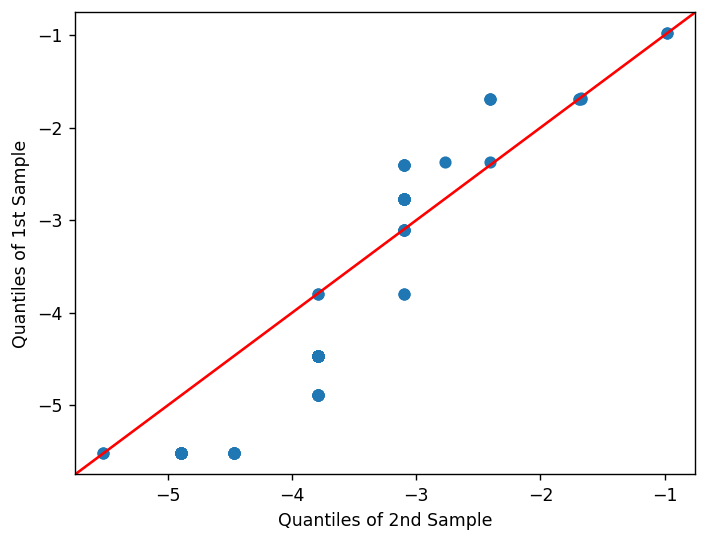

In [291]:
fig = sm.qqplot_2samples(bdq_mmp_variant_mics.query("Primary_Lineage=='2' & variant_binary_status==1")["log-MIC"].values, 
                        bdq_mmp_variant_mics.query("Primary_Lineage=='2' & variant_binary_status==0")["log-MIC"].values,
                         line="45"
                       )

In [272]:
bdq_mmp_variant_mics.query("variant_binary_status==1")["Lineage_1"].value_counts(dropna=False)

2.2.1    92
NaN      21
Name: Lineage_1, dtype: int64

In [275]:
bdq_mmp_variant_mics.query("variant_binary_status==1")

,sample_id,medium,MIC_lower,MIC_upper,Lower_bracket,Upper_bracket,mic_value,resolved_symbol,variant_category,predicted_effect,variant_allele_frequency,variant_binary_status,position,Sample_ID,Primary_Lineage,Lineage_1,Lineage_2
76,810022,MGIT,0.0000,0.125,(,],0.06250,mmpS5,c.-74G>T,upstream_gene_variant,0.99,1.0,778979,810022.0,2,2.2.1,NaN
122,840,MGIT,0.0625,0.125,(,],0.09375,mmpS5,c.-74G>T,upstream_gene_variant,1.00,1.0,778979,840.0,2,2.2.1,NaN
153,810086,MGIT,0.0000,0.125,(,],0.06250,mmpS5,c.-74G>T,upstream_gene_variant,1.00,1.0,778979,810086.0,2,2.2.1,NaN
169,823072,MGIT,2.0000,4.000,(,],3.00000,mmpS5,c.-74G>T,upstream_gene_variant,1.00,1.0,778979,NaN,NaN,NaN,NaN
173,823314,MGIT,0.5000,1.000,(,],0.75000,mmpS5,c.-74G>T,upstream_gene_variant,1.00,1.0,778979,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7119,23918,UKMYC5,0.0000,0.015,(,],0.00750,mmpS5,c.-74G>T,upstream_gene_variant,1.00,1.0,778979,23918.0,2,2.2.1,NaN
7295,7857,UKMYC5,0.0000,0.015,(,],0.00750,mmpS5,c.-74G>T,upstream_gene_variant,0.99,1.0,778979,7857.0,2,2.2.1,NaN
7770,24124,UKMYC5,0.0000,0.015,(,],0.00750,mmpS5,c.-74G>T,upstream_gene_variant,1.00,1.0,778979,24124.0,2,2.2.1,NaN
11564,22599,UKMYC5,0.0000,0.015,(,],0.00750,mmpS5,c.-74G>T,upstream_gene_variant,0.98,1.0,778979,22599.0,2,2.2.1,NaN


In [183]:
who_variants_combined.query("mutation=='mmpS5_c.-74G>T'")

,drug,confidence,mutation
14124,BDQ,3) Uncertain significance,mmpS5_c.-74G>T
14125,CFZ,3) Uncertain significance,mmpS5_c.-74G>T


In [277]:
np.max(bdq_mmp_variant_mics["mic_value"])

8.0

In [397]:
bdq_mmp_variant_mics.query("sample_id in @keep_samples").Lineage.unique()

array(['2.2.1', '4.1.2.1,2.2.1', '4.3.3,2.2.1', '4.2.1,2.2.1',
       '2.2.1,4.3.2', '2.2.1,4.1.1.1', '2.2.1,4.5', '2.2.2,2.2.1',
       '2.2.1,4', '2.2.1,1.1.1.1', '4.4.1.1,2.2.1', '2.2.1,1.1.1',
       '1,2.2.1', '2.2.1,4.4.1.2', '2.2.1,4.8', '2.2.1,4.4',
       '2.2.1,1.2.2', '2.2.1,4.4.2', '2.2.1,1.1.3', '2.2.1,4.3.4.2',
       '2.2.1,1.1.2', '4.3,2.2.1', '2.2.1,1.1', '2.2.1,4.7', '2.2.1,4.9',
       '2.2.1,1.2.1', '2.2.1,3.1.2'], dtype=object)

In [401]:
bdq_mmp_variant_mics.query("sample_id in @keep_samples").groupby("variant_binary_status")["mic_value"].mean()

variant_binary_status
0.0    0.052006
1.0    0.045929
Name: mic_value, dtype: float64

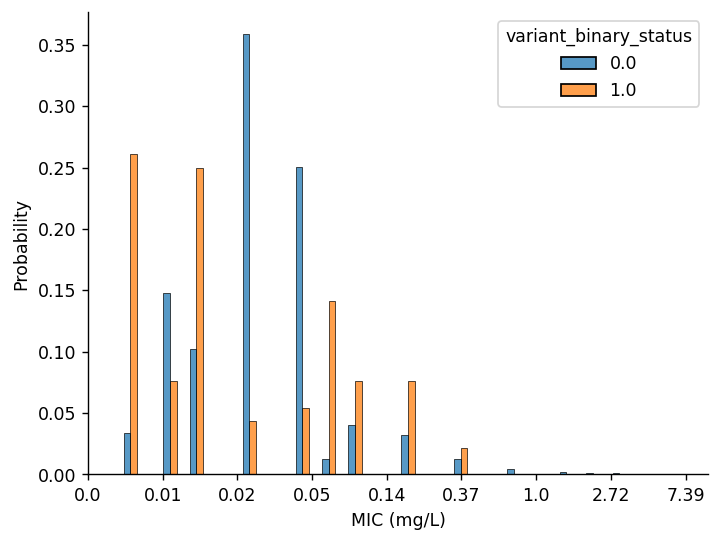

In [398]:
bdq_mmp_variant_mics["log-MIC"] = np.log(bdq_mmp_variant_mics["mic_value"])

fig, ax = plt.subplots()
sns.histplot(data=bdq_mmp_variant_mics.query("sample_id in @keep_samples"), x="log-MIC", hue="variant_binary_status", stat="probability", common_norm=False, multiple='dodge', 
             ax=ax, #kde=True
            )

plt.xlabel("MIC (mg/L)")
#plt.legend(loc="center right")
ax.set_xticks(ticks=ax.get_xticks(), labels=np.round(np.exp(ax.get_xticks()), 2))
plt.xlim(xmax=np.log(10))
sns.despine()
plt.savefig("/home/sak0914/bedaquiline_MIC_L2.2.1.png", dpi=300)

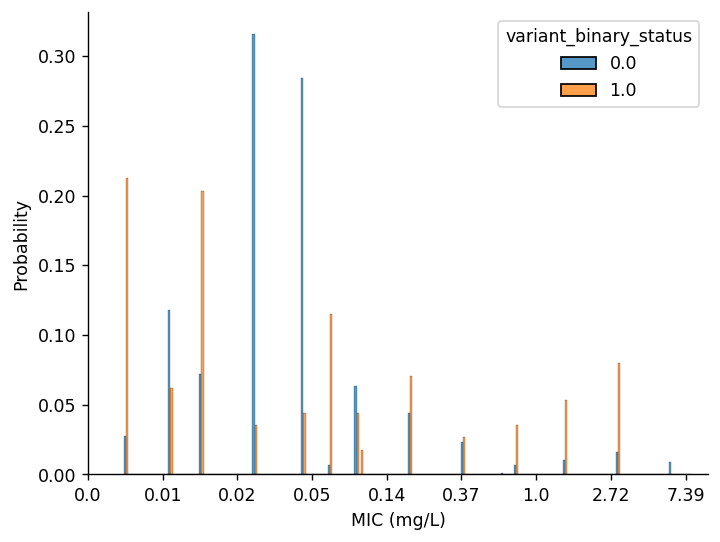

In [235]:
bdq_mmp_variant_mics["log-MIC"] = np.log(bdq_mmp_variant_mics["mic_value"])

fig, ax = plt.subplots()
sns.histplot(data=bdq_mmp_variant_mics, x="log-MIC", hue="variant_binary_status", stat="probability", common_norm=False, multiple='dodge', 
             ax=ax, #kde=True
            )

plt.xlabel("MIC (mg/L)")
#plt.legend(loc="center right")
ax.set_xticks(ticks=ax.get_xticks(), labels=np.round(np.exp(ax.get_xticks()), 2))
plt.xlim(xmax=np.log(10))
sns.despine()
# plt.show()

In [208]:
bdq_mmp_variant_mics.medium.value_counts()

UKMYC5                                             5833
UKMYC6                                             5445
MGIT                                               1145
7H11                                                 42
7H10                                                 13
Frozen Broth Microdilution Plate (PMID31969421)       2
M24 BMD                                               1
Name: medium, dtype: int64

In [217]:
bdq_mmp_variant_mics.query("variant_binary_status==1").medium.unique()

array(['MGIT', 'UKMYC6', 'UKMYC5'], dtype=object)

In [167]:
# sns.ecdfplot(data=bdq_mmp_variant_mics, x="log-MIC", hue="variant_binary_status")

phenotype
variant_binary_status phenotype           
0.0                   0               1260
                      1                866
1.0                   0                  3
                      1                 36

In [72]:
homoplasy = pd.read_excel("../data/Vargas_homoplasy.xlsx", sheet_name=None)

if len(homoplasy) == 1:
    homoplasy = homoplasy["Sheet1"]

In [88]:
homoplasy.loc[homoplasy["Gene Symbol"].str.contains("ahpC")].columns

Index(['H37Rv Position', 'Ref Allele', 'Alt Allele', 'Minor Allele',
       'Locus Tag', 'Gene Symbol', 'Gene Category', 'Genomic Coord',
       'SNP Type', 'AA change', 'L1', 'L2', 'L3', 'L4A', 'L4B', 'L4C', 'L5',
       'L6', 'Homoplasy Score', '# Minor', 'Homoplasy Score / # Minor'],
      dtype='object')

In [92]:
homoplasy["AA change"].unique()

array(['S315T', 'S450L', 'K43R', ..., 'A107V', 'P104P', 'R103H'],
      dtype=object)

In [93]:
homoplasy.loc[homoplasy["AA change"]=='D73H']

,H37Rv Position,Ref Allele,Alt Allele,Minor Allele,Locus Tag,Gene Symbol,Gene Category,Genomic Coord,SNP Type,AA change,...,L2,L3,L4A,L4B,L4C,L5,L6,Homoplasy Score,# Minor,Homoplasy Score / # Minor


In [95]:
homoplasy.loc[homoplasy["Gene Symbol"].str.contains("ahpC")][['H37Rv Position', 'Ref Allele', 'Alt Allele', 'Minor Allele', 'Locus Tag', 'Gene Symbol', 'SNP Type', 'AA change', 'Homoplasy Score', '# Minor', 'Homoplasy Score / # Minor']]



,H37Rv Position,Ref Allele,Alt Allele,Minor Allele,Locus Tag,Gene Symbol,SNP Type,AA change,Homoplasy Score,# Minor,Homoplasy Score / # Minor
203,2726141,C,T,T,Rv2427Ac_Rv2428,Rv2427Ac_ahpC,I,None,58,92,0.630435
216,2726145,G,A,A,Rv2427Ac_Rv2428,Rv2427Ac_ahpC,I,None,53,85,0.623529
306,2726142,G,A,A,Rv2427Ac_Rv2428,Rv2427Ac_ahpC,I,None,39,49,0.795918
332,2726112,C,T,T,Rv2427Ac_Rv2428,Rv2427Ac_ahpC,I,None,37,48,0.770833
492,2726121,C,T,T,Rv2427Ac_Rv2428,Rv2427Ac_ahpC,I,None,25,32,0.781250
669,2726141,C,A,A,Rv2427Ac_Rv2428,Rv2427Ac_ahpC,I,None,17,91,0.186813


In [83]:
who_all = pd.read_csv("/n/data1/hms/dbmi/farhat/Sanjana/MIC_data/WHO_resistance_variants_all.csv")

In [87]:
who_all.query("drug=='INH' & confidence=='3) Uncertain significance' & variant=='ahpC_D73H'")

,drug,genome_index,confidence,gene,variant
9174,INH,2726409,3) Uncertain significance,ahpC,ahpC_D73H


In [82]:
who_variants_combined.query("mutation=='ahpC_p.Asp73His'")

,drug,confidence,mutation
3865,INH,3) Uncertain significance,ahpC_p.Asp73His


In [61]:
len(bdq_mmp_variant.query("phenotypic_category=='WHO'")), len(bdq_mmp_variant.query("phenotypic_category=='WHO'").sample_id.unique())

(2165, 2165)

In [62]:
len(bdq_mmp_variant), len(bdq_mmp_variant.sample_id.unique())

(14135, 14135)

In [55]:
pd.DataFrame(bdq_mmp_variant.groupby(["variant_binary_status", "phenotype"], dropna=False)["phenotype"].count())

phenotype
variant_binary_status phenotype           
0.0                   0              13004
                      1               1000
1.0                   0                 94
                      1                 37

In [59]:
full_results_dict["Bedaquiline"]["Model_3"].query("mutation=='mmpS5_c.-74G>T'")[["mutation", "Odds_Ratio", "OR_LB", "OR_UB", "BH_pval", "Num_Isolates", "PPV", "PPV_LB", "PPV_UB", "TP", "FP", "TN", "FN", 'regression_confidence', 'High_Predictive_Value']]

,mutation,Odds_Ratio,OR_LB,OR_UB,BH_pval,Num_Isolates,PPV,PPV_LB,PPV_UB,TP,FP,TN,FN,regression_confidence,High_Predictive_Value
3,mmpS5_c.-74G>T,1.693998,1.467861,2.044834,0.0,39.0,0.923077,0.791298,0.983847,36.0,3.0,1259.0,863.0,Assoc w R - strict,1.0


In [58]:
full_results_dict["Bedaquiline"]["Model_11"].query("mutation=='mmpS5_c.-74G>T'")[["mutation", "Odds_Ratio", "OR_LB", "OR_UB", "BH_pval", "Num_Isolates", "PPV", "PPV_LB", "PPV_UB", "TP", "FP", "TN", "FN", 'regression_confidence', 'High_Predictive_Value']]

,mutation,Odds_Ratio,OR_LB,OR_UB,BH_pval,Num_Isolates,PPV,PPV_LB,PPV_UB,TP,FP,TN,FN,regression_confidence,High_Predictive_Value
4,mmpS5_c.-74G>T,1.267942,1.20112,1.332398,0.0,131.0,0.282443,0.207294,0.367703,37.0,94.0,12987.0,995.0,Assoc w R,1.0


In [52]:
bdq_mmp_variant.query("phenotypic_category=='WHO'").shape

(2165, 9)

In [46]:
bdq_mmp_variant.groupby("variant_binary_status", dropna=False)["phenotype"].mean()

variant_binary_status
0.0    0.071408
1.0    0.282443
Name: phenotype, dtype: float64

In [35]:
full_results_dict["Bedaquiline"]["Model_3"].query("AUC_BH_pval > 0.05").High_Predictive_Value.unique()


array([0.])

In [36]:
full_results_dict["Bedaquiline"]["Model_3"].query("AUC_BH_pval < 0.05").High_Predictive_Value.unique()

array([1.])

In [54]:
len(set(full_results_dict["Rifampicin"]["Model_3"].query("High_Predictive_Value==1")["mutation"]).union(full_results_dict["Rifampicin"]["Model_11"].query("High_Predictive_Value==1")["mutation"]))

27

In [66]:
len(set(full_results_dict["Rifampicin"]["Model_7"].query("High_Predictive_Value==1")["mutation"]).union(full_results_dict["Rifampicin"]["Model_15"].query("High_Predictive_Value==1")["mutation"]))

1

In [70]:
set(full_results_dict["Rifampicin"]["Model_7"].query("High_Predictive_Value==1")["mutation"]).union(full_results_dict["Rifampicin"]["Model_15"].query("High_Predictive_Value==1")["mutation"])

{'Rv2752c_p.Asn30Ser'}

In [55]:
len(set(full_results_dict["Rifampicin"]["Model_7"].query("High_Predictive_Value==1")["mutation"]).union(full_results_dict["Rifampicin"]["Model_15"].query("High_Predictive_Value==1")["mutation"]))

1

In [71]:
set(full_results_dict["Rifampicin"]["Model_7"].query("regression_confidence=='Assoc w S - strict'")["mutation"]).union(full_results_dict["Rifampicin"]["Model_15"].query("regression_confidence=='Assoc w S - strict'")["mutation"])

{'mtrB_p.Pro18Ser'}

In [58]:
full_results_dict["Rifampicin"]["Model_7"].query("mutation=='Rv2752c_p.Asn30Ser'")[['mutation', 'Tier', 'predicted_effect', 'position', 'confidence_V1',
       'Odds_Ratio', 'OR_LB', 'OR_UB', 'BH_pval',
       'LRT_BH_pval', 'AUC_BH_pval', 'Num_Isolates',
       'TP', 'FP', 'PPV', 'High_Predictive_Value',
       'LR+', 'LR-', 'PPV_LB']]

,mutation,Tier,predicted_effect,position,confidence_V1,Odds_Ratio,OR_LB,OR_UB,BH_pval,LRT_BH_pval,AUC_BH_pval,Num_Isolates,TP,FP,PPV,High_Predictive_Value,LR+,LR-,PPV_LB
19,Rv2752c_p.Asn30Ser,2.0,missense_variant,3066103,3) Uncertain significance,1.105124,1.050165,1.166855,0.0,0.000421,0.0,12.0,6.0,6.0,0.5,1.0,2.079002,0.99969,0.210945


In [60]:
len(full_results_dict["Rifampicin"]["Model_7"].loc[~pd.isnull(full_results_dict["Rifampicin"]["Model_7"]["AUC_BH_pval"])])

2

In [65]:
full_results_dict["Rifampicin"]["Model_7"].loc[~pd.isnull(full_results_dict["Rifampicin"]["Model_7"]["AUC_BH_pval"])][['mutation', 'Tier', 'predicted_effect', 'position', 'confidence_V1',
       'Odds_Ratio', 'OR_LB', 'OR_UB', 'BH_pval',
       'LRT_BH_pval', 'AUC_pval', 'AUC_BH_pval', 'Num_Isolates',
       'TP', 'FP', 'PPV', 'High_Predictive_Value',
       'LR+', 'LR-', 'PPV_LB']]

,mutation,Tier,predicted_effect,position,confidence_V1,Odds_Ratio,OR_LB,OR_UB,BH_pval,LRT_BH_pval,AUC_pval,AUC_BH_pval,Num_Isolates,TP,FP,PPV,High_Predictive_Value,LR+,LR-,PPV_LB
2,rpoC_p.Glu1092Asp,2.0,missense_variant,766645,5) Not assoc w R,1.216332,1.139563,1.296843,0.0,0.000716,0.1,0.809487,2697.0,1711.0,986.0,0.634409,0.0,3.607680,0.871022,0.615909
19,Rv2752c_p.Asn30Ser,2.0,missense_variant,3066103,3) Uncertain significance,1.105124,1.050165,1.166855,0.0,0.000421,0.0,0.000000,12.0,6.0,6.0,0.500000,1.0,2.079002,0.999690,0.210945


In [59]:
full_results_dict["Rifampicin"]["Model_15"].query("regression_confidence=='Assoc w S - strict'")[['mutation', 'Tier', 'predicted_effect', 'position', 'confidence_V1',
       'Odds_Ratio', 'OR_LB', 'OR_UB', 'BH_pval',
       'LRT_BH_pval', 'AUC_BH_pval', 'Num_Isolates',
       'TP', 'FP', 'PPV', 'High_Predictive_Value',
       'LR+', 'LR-', 'PPV_LB']]

,mutation,Tier,predicted_effect,position,confidence_V1,Odds_Ratio,OR_LB,OR_UB,BH_pval,LRT_BH_pval,AUC_BH_pval,Num_Isolates,TP,FP,PPV,High_Predictive_Value,LR+,LR-,PPV_LB
3436,mtrB_p.Pro18Ser,2.0,missense_variant,3626562,NaN,0.718734,0.649597,0.795039,0.0,5.840890e-07,0.802941,12285.0,5598.0,6687.0,0.455678,0.0,0.461389,1.439499,0.446842


In [51]:
full_results_dict["Rifampicin"]["Model_11"].query("regression_confidence=='Assoc w S - strict'")[['mutation', 'Tier', 'predicted_effect', 'position', 'confidence_V1',
       'Odds_Ratio', 'OR_LB', 'OR_UB', 'BH_pval',
       'LRT_BH_pval', 'AUC_BH_pval', 'Num_Isolates',
       'TP', 'FP', 'PPV', 'High_Predictive_Value',
       'LR+', 'LR-', 'PPV_LB']]

,mutation,Tier,predicted_effect,position,confidence_V1,Odds_Ratio,OR_LB,OR_UB,BH_pval,LRT_BH_pval,AUC_BH_pval,Num_Isolates,TP,FP,PPV,High_Predictive_Value,LR+,LR-,PPV_LB
947,rpoB_c.-83A>G,1.0,upstream_gene_variant,759724,3) Uncertain significance,0.931787,0.902993,0.950219,0.0,0.02934,0.816279,37.0,31.0,6.0,0.837838,0.0,2.815212,0.999352,0.679863


In [42]:
summary_dfs_dict["Rifampicin"]

,"Tier1,WHO","Tier2,WHO","Tier1,ALL","Tier2,ALL"
regression_confidence,,,,
Assoc w R,91,103,112,128
Assoc w R - strict,39,1,44,4
Assoc w S,24,40,24,46
Assoc w S - strict,0,0,1,1
Evidence against Assoc,661,2701,769,3258


# MIC Analyses

In [268]:
# # hard coded paths to preserve the model hierarchy
# mic_analyses_lst = ["tiers=1/dropAF_noSyn_poolSeparate",
#                     "tiers=1/dropAF_noSyn_unpooled",
#                     "tiers=1+2/dropAF_noSyn_poolSeparate",
#                     "tiers=1+2/dropAF_noSyn_unpooled",
#                    ]

# export_binary_mic_analyses(drugs_lst, "MIC", mic_analyses_lst)

# Binary Analysis Summaries File

## Make an Excel file summarizing the results for each drug for the binary analyses

## Break down results by FDR (Significant), OR > 1, Primary Analysis, PPV ≥ 25%, and True Positive (# with variant and resistant) ≥ 5

In [269]:
# def generate_summary_data(drug, folder):
    
#     # read in Excel file with all the sheets 
#     df = pd.read_excel(f"../results/{folder}/{drug}.xlsx", sheet_name=None)

#     # combine sheets into a single dataframe and keep only the first instance of every mutation
#     df = pd.concat(list(df.values())).drop_duplicates("mutation", keep="first")

#     # OR > 1 or OR < 1 --> associated with resistance or susceptibility
#     df["OR>1"] = (df["Odds_Ratio"] > 1)
#     df["PPV_LB≥0.25"] = (df["PPV_LB"] >= 0.25)
#     df["TP≥5"] = (df["TP"] >= 5)

#     df[["OR>1", "PPV_LB≥0.25", "TP≥5"]] = df[["OR>1", "PPV_LB≥0.25", "TP≥5"]].fillna(0).astype(int)
#     df["pooled"] = [0 if "unpooled" in val else 1 for val in df["pool_type"].values]

#     summary_cols = ["OR>1", "PPV_LB≥0.25", "TP≥5", "Significant", "Tier", "Phenos", "synonymous", "pooled"]
#     summary = pd.DataFrame(df[summary_cols].value_counts()).reset_index().rename(columns={0:"Count"})
#     summary = summary[["Count"] + summary_cols].sort_values(by=summary_cols, ascending=[False, False, False, False, True, False, True, True])

#     summary.loc[(summary["OR>1"] == 1) & 
#                 (summary["PPV_LB≥0.25"] == 1) &
#                 (summary["TP≥5"] == 1), "Expert_PASS"
#                 ] = 1

#     summary["Expert_PASS"] = summary["Expert_PASS"].fillna(0).astype(int)

#     return summary.rename(columns={"Tier": "Gene_Tier", "pooled": "LOF_inframe_pooling"}).reset_index(drop=True)

In [270]:
# analysis_summaries = {}
# folder = "BINARY"

# for drug in np.sort(drugs_lst):
    
#     if os.path.isfile(f"../results/{folder}/{drug}.xlsx"):
#         analysis_summaries[drug] = generate_summary_data(drug, folder)
    
# # write results to an Excel file, where each sheet name is a drug
# with pd.ExcelWriter("../results/ALLDrugs_summaries.xlsx") as file:
   
#     for key, val in analysis_summaries.items():
#         val.to_excel(file, sheet_name=key, index=False)

# CC vs. CC-ATU Analyses

Export only variants that would pass the Expert rule:

<ul>
    <li>Odds Ratio > 1</li>
    <li>N_resistant (i.e. true positive) ≥ 5</li>
    <li>PPV_LB ≥ 0.25</li>
    <li>Benjamini-Hochberg p-value < 0.01</li>
</ul>

In [110]:
# def export_cc_atu_analyses(drugs_lst, pval_thresh=0.01):
#     '''
#     This function combines the CC and CC-ATU analyses for each drug. 
#     '''
    
#     if not os.path.isdir("../results/ATU"):
#         os.mkdir("../results/ATU")
    
#     # hard coded paths to preserve the model hierarchy
#     analysis_paths = ["tiers=1/dropAF_noSyn_poolSeparate",
#                       "tiers=1/dropAF_noSyn_poolALL",
#                       "tiers=1/dropAF_noSyn_unpooled",
#                       "tiers=1+2/dropAF_noSyn_poolSeparate",
#                       "tiers=1+2/dropAF_noSyn_poolALL",
#                       "tiers=1+2/dropAF_noSyn_unpooled",
#     ]
    
#     for drug in drugs_lst:
        
#         all_analyses = {}
        
#         for i, model_path in enumerate(analysis_paths):

#             if os.path.isfile(os.path.join(analysis_dir, drug, "ATU", model_path, "model_analysis_with_stats_CC.csv")):
            
#                 cc = pd.read_csv(os.path.join(analysis_dir, drug, "ATU", model_path, "model_analysis_with_stats_CC.csv"))
#                 cc_atu = pd.read_csv(os.path.join(analysis_dir, drug, "ATU", model_path, "model_analysis_with_stats_CC_ATU.csv"))

#                 cc.loc[(cc["Odds_Ratio"] > 1) & 
#                        (cc["TP"] >= 5) &
#                        (cc["PPV_LB"] >= 0.25) & 
#                        (cc["BH_pval"] < pval_thresh), "Expert_PASS"
#                       ] = 1

#                 cc_atu.loc[(cc_atu["Odds_Ratio"] > 1) & 
#                            (cc_atu["TP"] >= 5) &
#                            (cc_atu["PPV_LB"] >= 0.25) & 
#                            (cc_atu["BH_pval"] < pval_thresh), "Expert_PASS"
#                           ] = 1

#                 cc["ATU"] = 0
#                 cc_atu["ATU"] = 1

#                 combined_df = pd.concat([cc.query("Expert_PASS == 1"), cc_atu.query("Expert_PASS == 1")])
#                 del combined_df["Expert_PASS"]
                
#                 combined_df["Tier"] = [2 if "+2" in model_path else 1][0]
#                 combined_df["Phenos"] = ["ALL" if "ALL" in model_path else "WHO"][0]
#                 combined_df["pool_type"] = model_path.split("_")[-1]
#                 combined_df["synonymous"] = int("withSyn" in model_path)
#                 combined_df["HET"] = ["DROP" if "drop" in model_path else "AF"][0]

#                 # remove principal components
#                 combined_df = combined_df.loc[~combined_df["mutation"].str.contains("PC", case=True)]
            
#                 all_analyses[f"Model_{i+1}"] = combined_df.sort_values("Odds_Ratio", ascending=False)

#         if len(all_analyses) > 0:
                
#             with pd.ExcelWriter(f"../results/ATU/{drug}.xlsx") as file:

#                 for key, val in all_analyses.items():
#                     val.to_excel(file, sheet_name=key, index=False)
                  
#             print(f"Finished {drug}!")

In [111]:
# export_cc_atu_analyses(drugs_lst)

# Volcano Plots

In [37]:
def volcano_plot(drug, folder, plot_x, pval_col="BH_pval", color_col="Phenos", saveFig=None):
    '''
    This function generates a volcano scatterplot of p-values against odds ratios to visualize the results for each drug. 
    
    It generates 2 plots for each drug: one for the primary analyses and another for the additional variants picked up by the secondary analyses. Separating them makes the secondary results
    easier to see because the effect sizes for those are much smaller, and they can get obscured by the primary analysis results. 
    
    Arguments:
    
        df = dataframe of results
        plot_x = column in df to plot as the x variable
        plot_y = column in df to plot as the y variable
        pval_col = p-value column to plot (i.e. p-value, Bonferroni, or Benjamini-Hochberg)
        drug = drug name for plotting
        color_col = column in df to color point by. Default is Significant
        or_thresh = to clean up the plot, you can exclude some mutations with very small effect sizes. or_thresh should be a value in [0, ∞). i.e. a threshold of 0.01 will
                    exclude variants with odds ratios in [0.99, 1.01]
        save_fig = file name to save plot to. If it is None, the plot is rendered in the notebook.
        
    Primary analysis: Tier = 1, Phenos = WHO, unpooled = False, synonymous = False, HET mutations = DROP
    
    The function computes the log odds ratio, negative logarithm of p-values, and the logarithm of the negative log of p-values. 
    It plots the logarithm of the negative log of p-values vs. the coefficient in regression (linear or logistic). The log of the logistic regression coefficient is the log-Odds
    '''
    
    # read in Excel file with all the sheets 
    fName = f"../results/{folder}/{drug}.xlsx"
    
    if os.path.isfile(fName):
        
        # plot only unpooled mutation restuls
        if drug == "Pretomanid":
            df = pd.read_excel(fName, sheet_name=["Model_11"])
        else:
            df = pd.read_excel(fName, sheet_name=["Model_3", "Model_7", "Model_11", "Model_15"])

        # combine sheets into a single dataframe and keep only the first instance of every mutation
        df = pd.concat([single_df.loc[~pd.isnull(single_df["Odds_Ratio"])] for single_df in df.values()], axis=0)

        fig, ax = plt.subplots(1, 2, figsize=(12, 4))

        plot_df = df.copy()

        # add color categories
        plot_df.loc[(plot_df["Phenos"] == "WHO") & (plot_df["Tier"]==1) & (plot_df[pval_col] < 0.05), "color_col"] = "WHO"
        plot_df.loc[(plot_df["Phenos"] == "WHO") & (plot_df["Tier"]==2) & (plot_df[pval_col] < 0.01), "color_col"] = "WHO"

        plot_df.loc[(plot_df["Phenos"] == "ALL") & (plot_df["Tier"]==1) & (plot_df[pval_col] < 0.05), "color_col"] = "ALL"
        plot_df.loc[(plot_df["Phenos"] == "ALL") & (plot_df["Tier"]==2) & (plot_df[pval_col] < 0.01), "color_col"] = "ALL"

        # the remaining are insignificant
        plot_df["color_col"] = plot_df["color_col"].fillna("NOT")

        if plot_df[pval_col].min() == 0:
            second_smallest = np.sort(np.unique(plot_df[pval_col]))[1]
            plot_df[pval_col] += second_smallest

        plot_df[f"neg_log_{pval_col}"] = -np.log(plot_df[pval_col])
        plot_df[f"log_neg_log_{pval_col}"] = np.log(plot_df[f"neg_log_{pval_col}"])
        color_palette = {"WHO":sns.color_palette("tab10").as_hex()[0], "ALL":sns.color_palette("tab10").as_hex()[1], "NOT":"lightgray"}

        if plot_x == "coef":
            plot_df["coef"] = np.log(plot_df["Odds_Ratio"])
        plot_y = f"log_neg_log_{pval_col}"

        sns.scatterplot(data=plot_df.query("Tier==1"), 
                        x=plot_x, 
                        y=plot_y, 
                        alpha=0.8,
                        hue="color_col", 
                        linewidth=0.25,
                        edgecolor='white',
                        s=30,
                        palette=color_palette,
                        ax=ax[0]
                       )

        sns.scatterplot(data=plot_df.query("Tier==2"), 
                        x=plot_x, 
                        y=plot_y, 
                        alpha=0.8,
                        hue="color_col",
                        linewidth=0.25,
                        edgecolor='white',
                        s=30,
                        palette=color_palette,
                        ax=ax[1]
                       )

        
        if plot_x == "coef":
            baseline = 0
        else:
            baseline = 1
            
        bound_0 = np.max(np.abs(plot_df.query("Tier==1")[plot_x]))*1.1
        ax[0].set_xlim(baseline - (bound_0-baseline), baseline + (bound_0-baseline))
        ax[0].legend(title='')
        ax[0].set_title(f'''Tier 1: {len(plot_df.query("Tier==1 & color_col != 'NOT'"))} Mutations Significant in Ridge''')

        if drug != "Pretomanid":
            bound_1 = np.max(np.abs(plot_df.query("Tier==2")[plot_x]))*1.1
            ax[1].set_xlim(baseline - (bound_1-baseline), baseline + (bound_1-baseline))
            ax[1].legend(title='')
            ax[1].set_title(f'''Tier 2: {len(plot_df.query("Tier==2 & color_col != 'NOT'"))} Mutations Significant in Ridge''')

        sns.despine()

        if saveFig is not None:
            if not os.path.isdir(os.path.dirname(saveFig)):
                os.makedir(os.path.dirname(saveFig))
            plt.savefig(saveFig, dpi=300, bbox_inches="tight")
        else:
            plt.show()

        # return plot_df

In [38]:
def volcano_plot_by_significance(drug, color_dict, plot_x="coef", pval_col="AUC_BH_pval", saveFig=None):
    '''
    This function generates a volcano scatterplot of p-values against odds ratios to visualize the results for each drug. 
    
    It generates 2 plots for each drug: one for the primary analyses and another for the additional variants picked up by the secondary analyses. Separating them makes the secondary results
    easier to see because the effect sizes for those are much smaller, and they can get obscured by the primary analysis results. 
    
    Arguments:
    
        df = dataframe of results
        plot_x = column in df to plot as the x variable
        plot_y = column in df to plot as the y variable
        pval_col = p-value column to plot (i.e. p-value, Bonferroni, or Benjamini-Hochberg)
        drug = drug name for plotting
        color_col = column in df to color point by. Default is Significant
        or_thresh = to clean up the plot, you can exclude some mutations with very small effect sizes. or_thresh should be a value in [0, ∞). i.e. a threshold of 0.01 will
                    exclude variants with odds ratios in [0.99, 1.01]
        save_fig = file name to save plot to. If it is None, the plot is rendered in the notebook.
        
    Primary analysis: Tier = 1, Phenos = WHO, unpooled = False, synonymous = False, HET mutations = DROP
    
    The function computes the log odds ratio, negative logarithm of p-values, and the logarithm of the negative log of p-values. 
    It plots the logarithm of the negative log of p-values vs. the coefficient in regression (linear or logistic). The log of the logistic regression coefficient is the log-Odds
    '''
    
    model_lst =  ["Model_3", "Model_7", "Model_11", "Model_15"]
    dfs_lst = []

    for key, df in full_results_dict[drug].items():
        if key in model_lst:
            dfs_lst.append(df.loc[~pd.isnull(df["Odds_Ratio"])])

    plot_df = pd.concat(dfs_lst, axis=0)

    if plot_df[pval_col].min() == 0:
        second_smallest = np.sort(np.unique(plot_df[pval_col]))[1]
        plot_df[pval_col] += second_smallest

    plot_df[f"neg_log_{pval_col}"] = -np.log(plot_df[pval_col])
    plot_df[f"log_neg_log_{pval_col}"] = np.log(plot_df[f"neg_log_{pval_col}"])
    
#     groups = ["1) Assoc w R", "2) Assoc w R - Interim", "3) Uncertain", "4) Assoc w S - Interim", "5) Assoc w S", "6) No Assoc"]
#     names = ["Assoc w R", "Assoc w R-Interim", "Uncertain", "Assoc w S-Interim", "Assoc w S", "No Assoc"]

#     plot_df["regression_confidence"] = plot_df["regression_confidence"].map(dict(zip(groups, names)))
    
    
    # categories = ["Evidence against Assoc", "Assoc w S", "Assoc w R", "Assoc w S - strict", "Assoc w R - strict"]
    # color_palette = dict(zip(categories, sns.color_palette("colorblind").as_hex()[:len(categories)]))
    # color_palette["Evidence against Assoc"] = "lightgray"
    
    plot_df["regression_confidence"] = plot_df["regression_confidence"].replace("Assoc w R - strict", "5").replace("Assoc w S - strict", "4")
    
    # lots of overlap between WHO and ALL groups, so don't double plot. Keep first (WHO)
    plot_df = plot_df.sort_values("regression_confidence", ascending=False).drop_duplicates("mutation", keep="last")
    plot_df["regression_confidence"] = plot_df["regression_confidence"].replace("5", "Assoc w R - strict").replace("4", "Assoc w S - strict").replace("Evidence against Assoc", "No Assoc")
    
    if plot_x == "coef":
        plot_df["coef"] = np.log(plot_df["Odds_Ratio"])
            
    plot_y = f"log_neg_log_{pval_col}"
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))

    sns.scatterplot(data=plot_df.query("Tier==1"), 
                    x=plot_x, 
                    y=plot_y, 
                    alpha=1,
                    hue="regression_confidence", 
                    linewidth=0.25,
                    edgecolor='white',
                    s=30,
                    palette=color_dict,
                    ax=ax[0]
                   )

    sns.scatterplot(data=plot_df.query("Tier==2"), 
                    x=plot_x, 
                    y=plot_y, 
                    alpha=1,
                    hue="regression_confidence",
                    linewidth=0.25,
                    edgecolor='white',
                    s=30,
                    palette=color_dict,
                    ax=ax[1]
                   )

    if plot_x == "coef":
        baseline = 0
    else:
        baseline = 1
        
    try:
        bound_0 = np.max(np.abs(plot_df.query("Tier==1")[plot_x]))*1.1
        ax[0].set_xlim(baseline - (bound_0-baseline), baseline + (bound_0-baseline))
        ax[0].legend(title='')
        
        bound_1 = np.max(np.abs(plot_df.query("Tier==2")[plot_x]))*1.1
        ax[1].set_xlim(baseline - (bound_1-baseline), baseline + (bound_1-baseline))
        ax[1].get_legend().remove()
    except:
        pass

    ax[0].set_title(f"{drug}, Tier 1")
    ax[1].set_title(f"{drug}, Tier 2")
    
    sns.despine()

    if saveFig is not None:
        if not os.path.isdir(os.path.dirname(saveFig)):
            os.makedir(os.path.dirname(saveFig))
        plt.savefig(saveFig, dpi=300, bbox_inches="tight")
    else:
        plt.show()

In [39]:
# https://imagecolorpicker.com/en

color_dict = {"Assoc w R - strict": "#c34a4f",
              "Assoc w R": "#e2a19e",
              "Assoc w S - strict": "#2b79c4",
              "Assoc w S": "#acbdd4",
              "No Assoc": "lightgray"
             }

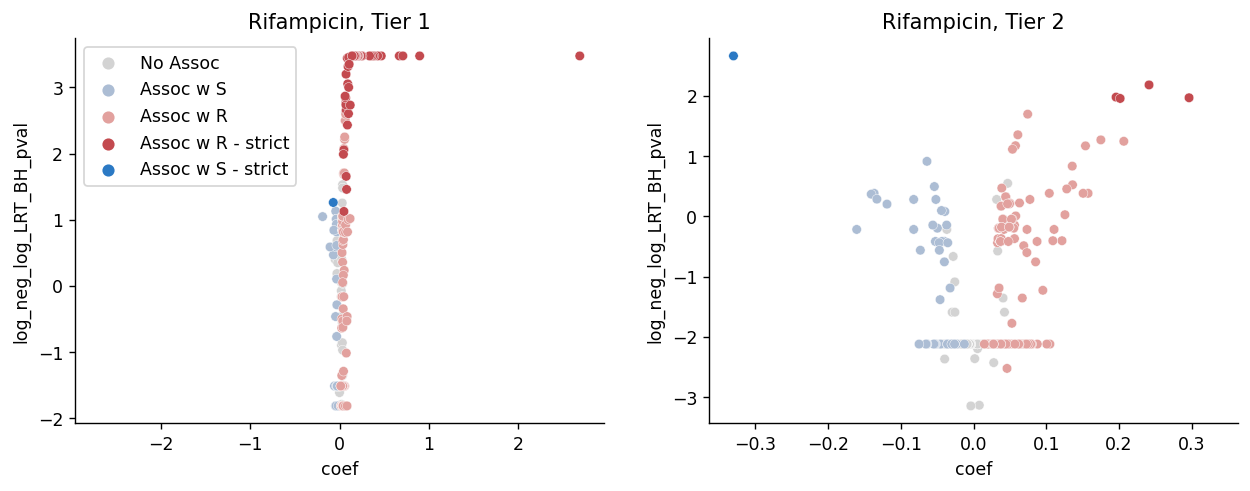

In [41]:
volcano_plot_by_significance("Rifampicin", color_dict, pval_col="LRT_BH_pval", saveFig="../results/Figures/RIF_volcano.png")

In [203]:
# for drug in np.sort(drugs_lst):
#     try:
#         volcano_plot_by_significance(drug, color_dict, pval_col="LRT_BH_pval")
#     except:
#         print(drug)

In [194]:
drug = "Rifampicin"
model_lst =  ["Model_3", "Model_7", "Model_11", "Model_15"]
dfs_lst = []

for key, df in full_results_dict[drug].items():
    if key in model_lst:
        dfs_lst.append(df.loc[~pd.isnull(df["Odds_Ratio"])])

# lots of overlap between WHO and ALL groups, so don't double plot. Keep first (WHO)
plot_df = pd.concat(dfs_lst, axis=0)#.drop_duplicates("mutation", keep="first")

In [197]:
plot_df.drop_duplicates("mutation", keep="first").query("Tier==2 & regression_confidence=='Assoc w R - strict'")

,mutation,Tier,predicted_effect,position,confidence_V1,Odds_Ratio,OR_LB,OR_UB,pval,BH_pval,...,Spec_UB,LR+_LB,LR+_UB,LR-_LB,LR-_UB,regression_confidence,High_Predictive_Value,Phenos,pool_type,synonymous
2,rpoC_p.Glu1092Asp,2.0,missense_variant,766645,5) Not assoc w R,1.216332,1.139563,1.296843,0.0,0.0,...,0.955703,3.348102,3.887383,0.862922,0.879198,Assoc w R - strict,0.0,WHO,unpooled,0.0


In [207]:
plot_df.drop_duplicates(["mutation", "Tier"], keep="first").query("Tier==2 & regression_confidence=='Assoc w R - strict'")

,mutation,Tier,predicted_effect,position,confidence_V1,Odds_Ratio,OR_LB,OR_UB,pval,BH_pval,...,Spec_UB,LR+_LB,LR+_UB,LR-_LB,LR-_UB,regression_confidence,High_Predictive_Value,Phenos,pool_type,synonymous
2,rpoC_p.Glu1092Asp,2.0,missense_variant,766645,5) Not assoc w R,1.216332,1.139563,1.296843,0.0,0.0,...,0.955703,3.348102,3.887383,0.862922,0.879198,Assoc w R - strict,0.0,WHO,unpooled,0.0


In [211]:
plot_df.query("mutation=='rpoC_p.Val483Gly'").sort_values("regression_confidence", ascending=False)

,mutation,Tier,predicted_effect,position,confidence_V1,Odds_Ratio,OR_LB,OR_UB,pval,BH_pval,...,Spec_UB,LR+_LB,LR+_UB,LR-_LB,LR-_UB,regression_confidence,High_Predictive_Value,Phenos,pool_type,synonymous
0,rpoC_p.Val483Gly,2.0,missense_variant,764817,NaN,1.344718,1.242714,1.460296,0.0,0.0,...,0.999489,58.482994,135.908209,0.923942,0.932313,Assoc w R - strict,0.0,ALL,unpooled,0.0
0,rpoC_p.Val483Gly,2.0,missense_variant,764817,NaN,1.351136,1.251374,1.477266,0.0,0.0,...,0.999527,66.864897,174.395519,0.907468,0.918555,Assoc w R,0.0,WHO,unpooled,0.0


In [213]:
plot_df.drop_duplicates("regression_confidence").sort_values("regression_confidence", ascending=False)

,mutation,Tier,predicted_effect,position,confidence_V1,Odds_Ratio,OR_LB,OR_UB,pval,BH_pval,...,Spec_UB,LR+_LB,LR+_UB,LR-_LB,LR-_UB,regression_confidence,High_Predictive_Value,Phenos,pool_type,synonymous
73,rpoB_p.Asp435Asn,1.0,missense_variant,761109,NaN,1.047448,1.021614,1.066732,0.014,0.069157,...,1.00000,NaN,inf,0.999311,0.999993,Evidence against Assoc,0.0,WHO,unpooled,0.0
745,rpoB_p.Gln436Asn,1.0,missense_variant,761108;761112,2) Assoc w R - Interim,0.981597,0.964968,1.000000,0.000,0.000000,...,1.00000,NaN,inf,0.999876,1.000040,Assoc w S,0.0,WHO,unpooled,0.0
0,rpoB_p.Ser450Leu,1.0,missense_variant,761154;761155,1) Assoc w R,13.996830,13.450316,14.703059,0.000,0.000000,...,0.99674,131.630401,196.405333,0.345859,0.363410,Assoc w R - strict,1.0,WHO,unpooled,0.0
23,rpoB_p.Pro45Ser,1.0,missense_variant,759939,3) Uncertain significance,1.138876,1.054409,1.192612,0.000,0.000000,...,1.00000,NaN,inf,0.995346,0.997525,Assoc w R,0.0,WHO,unpooled,0.0


In [208]:
plot_df.query("Tier==2 & regression_confidence=='Assoc w R - strict'")

,mutation,Tier,predicted_effect,position,confidence_V1,Odds_Ratio,OR_LB,OR_UB,pval,BH_pval,...,Spec_UB,LR+_LB,LR+_UB,LR-_LB,LR-_UB,regression_confidence,High_Predictive_Value,Phenos,pool_type,synonymous
2,rpoC_p.Glu1092Asp,2.0,missense_variant,766645,5) Not assoc w R,1.216332,1.139563,1.296843,0.0,0.0,...,0.955703,3.348102,3.887383,0.862922,0.879198,Assoc w R - strict,0.0,WHO,unpooled,0.0
0,rpoC_p.Val483Gly,2.0,missense_variant,764817,NaN,1.344718,1.242714,1.460296,0.0,0.0,...,0.999489,58.482994,135.908209,0.923942,0.932313,Assoc w R - strict,0.0,ALL,unpooled,0.0
1,rpoC_p.Val483Ala,2.0,missense_variant,764817,NaN,1.272722,1.183928,1.382687,0.0,0.0,...,0.999848,50.269027,187.835571,0.965086,0.970792,Assoc w R - strict,0.0,ALL,unpooled,0.0
3,rpoC_p.Asn698Ser,2.0,missense_variant,765462,NaN,1.223164,1.156612,1.275521,0.0,0.0,...,1.000000,NaN,inf,0.987087,0.990472,Assoc w R - strict,0.0,ALL,unpooled,0.0
5,rpoC_p.Glu1092Asp,2.0,missense_variant,766645,5) Not assoc w R,1.175690,1.116430,1.247490,0.0,0.0,...,0.960689,2.866597,3.303348,0.903668,0.915757,Assoc w R - strict,0.0,ALL,unpooled,0.0


In [165]:
# volcano_plot("Delamanid", "BINARY", "coef")

In [193]:
for drug in drugs_lst:
    if drug != "Isoniazid":
        for key, df in full_results_dict[drug].items():
            if "_3" in key or "_7" in key or "_11" in key or "_15" in key:
                if len(df.query("mutation.str.contains('Rv2752c') & regression_confidence != '6) No Assoc'")) > 0:
                    print(drug)

Levofloxacin
Levofloxacin
Ethambutol
Ethambutol
Moxifloxacin
Moxifloxacin
Rifampicin
Rifampicin


In [171]:
len(set(full_results_dict["Rifampicin"]["Model_3"].query("High_Predictive_Value==1").mutation).union(full_results_dict["Rifampicin"]["Model_11"].query("High_Predictive_Value==1").mutation))

25

In [183]:
len(set(full_results_dict["Rifampicin"]["Model_3"].query("regression_confidence=='Assoc w R - strict'").mutation).union(full_results_dict["Rifampicin"]["Model_11"].query("regression_confidence=='Assoc w R - strict'").mutation))

44

In [184]:
summary_dfs_dict["Rifampicin"]

,"Tier1,WHO","Tier2,WHO","Tier1,ALL","Tier2,ALL"
regression_confidence,,,,
Assoc w R,91,103,112,128
Assoc w R - strict,39,1,44,4
Assoc w S,24,40,25,47
Assoc w S - strict,0,0,0,0
Evidence against Assoc,661,2701,769,3258


In [186]:
full_results_dict["Rifampicin"]["Model_7"].query("regression_confidence=='Assoc w R - strict'")

,mutation,Tier,predicted_effect,position,confidence_V1,Odds_Ratio,OR_LB,OR_UB,pval,BH_pval,...,Spec_UB,LR+_LB,LR+_UB,LR-_LB,LR-_UB,regression_confidence,High_Predictive_Value,Phenos,pool_type,synonymous
2,rpoC_p.Glu1092Asp,2.0,missense_variant,766645,5) Not assoc w R,1.216332,1.139563,1.296843,0.0,0.0,...,0.955703,3.348102,3.887383,0.862922,0.879198,Assoc w R - strict,0.0,WHO,unpooled,0.0


In [190]:
for mut in full_results_dict["Rifampicin"]["Model_15"].query("regression_confidence=='Assoc w R - strict'").mutation.values:
    print(mut)

rpoC_p.Val483Gly
rpoC_p.Val483Ala
rpoC_p.Asn698Ser
rpoC_p.Glu1092Asp


In [202]:
full_results_dict["Rifampicin"]["Model_7"].query("regression_confidence=='Assoc w R - strict'")

,mutation,Tier,predicted_effect,position,confidence_V1,Odds_Ratio,OR_LB,OR_UB,pval,BH_pval,...,Spec_UB,LR+_LB,LR+_UB,LR-_LB,LR-_UB,regression_confidence,High_Predictive_Value,Phenos,pool_type,synonymous
2,rpoC_p.Glu1092Asp,2.0,missense_variant,766645,5) Not assoc w R,1.216332,1.139563,1.296843,0.0,0.0,...,0.955703,3.348102,3.887383,0.862922,0.879198,Assoc w R - strict,0.0,WHO,unpooled,0.0


,mutation,Tier,predicted_effect,position,confidence_V1,Odds_Ratio,OR_LB,OR_UB,pval,BH_pval,...,Spec_UB,LR+_LB,LR+_UB,LR-_LB,LR-_UB,regression_confidence,High_Predictive_Value,Phenos,pool_type,synonymous
0,rpoC_p.Val483Gly,2.0,missense_variant,764817,NaN,1.344718,1.242714,1.460296,0.0,0.0,...,0.999489,58.482994,135.908209,0.923942,0.932313,Assoc w R - strict,0.0,ALL,unpooled,0.0
1,rpoC_p.Val483Ala,2.0,missense_variant,764817,NaN,1.272722,1.183928,1.382687,0.0,0.0,...,0.999848,50.269027,187.835571,0.965086,0.970792,Assoc w R - strict,0.0,ALL,unpooled,0.0
3,rpoC_p.Asn698Ser,2.0,missense_variant,765462,NaN,1.223164,1.156612,1.275521,0.0,0.0,...,1.000000,NaN,inf,0.987087,0.990472,Assoc w R - strict,0.0,ALL,unpooled,0.0
5,rpoC_p.Glu1092Asp,2.0,missense_variant,766645,5) Not assoc w R,1.175690,1.116430,1.247490,0.0,0.0,...,0.960689,2.866597,3.303348,0.903668,0.915757,Assoc w R - strict,0.0,ALL,unpooled,0.0
